In [31]:
import tarfile
import os

# Path to the .tgz file
dataset_path = '/kaggle/input/flower-dataset-102/102flowers.tgz'

# Extraction directory
extract_path = '/kaggle/working/flowers/'

# Open and extract
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction completed!")

# Check the extracted folder
print(os.listdir(extract_path))


Extraction completed!
['jpg']


In [32]:
from PIL import Image

# List files
extract_path = '/kaggle/working/flowers/jpg'
img_files = os.listdir(extract_path)
print(f"Number of images: {len(img_files)}")
print(f"First few images: {img_files[:5]}")


Number of images: 8189
First few images: ['image_03901.jpg', 'image_06756.jpg', 'image_00458.jpg', 'image_00713.jpg', 'image_02278.jpg']


Total images: 8189


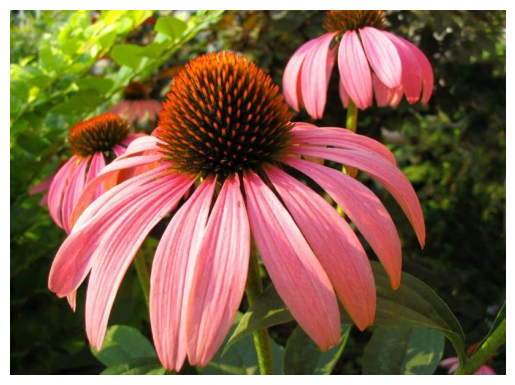

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Path to flower images
flower_folder = '/kaggle/working/flowers/jpg'

# Get list of images
img_files = os.listdir(flower_folder)
print(f"Total images: {len(img_files)}")

# Load and display first image using matplotlib
img_path = os.path.join(flower_folder, img_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()


In [34]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import random
import os

class FlowerInpaintingDataset(Dataset):
    def __init__(self, image_folder, transform=None, image_size=(128, 128)):
        self.image_folder = image_folder
        self.image_files = os.listdir(image_folder)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def generate_single_rectangle_mask(self):
        mask = Image.new('L', self.image_size, color=0)  # Black = known parts (0)
        draw = ImageDraw.Draw(mask)

        rect_min_size = 30
        rect_max_size = 60

        rect_w = random.randint(rect_min_size, rect_max_size)
        rect_h = random.randint(rect_min_size, rect_max_size)

        top_left_x = random.randint(0, self.image_size[0] - rect_w)
        top_left_y = random.randint(0, self.image_size[1] - rect_h)

        bottom_right_x = top_left_x + rect_w
        bottom_right_y = top_left_y + rect_h

        draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], fill=255)

        return mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('RGB').resize(self.image_size)

        # Apply transform to image
        if self.transform:
            image = self.transform(image)

        # Generate mask
        mask = self.generate_single_rectangle_mask()
        mask_tensor = transforms.ToTensor()(mask)

        # Create masked image
        masked_image = image * (1 - mask_tensor)

        return image, masked_image, mask_tensor


In [35]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Dataset
dataset = FlowerInpaintingDataset(image_folder='/kaggle/working/flowers/jpg', transform=transform)

# Define the split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# DataLoader
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, num_workers = 3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


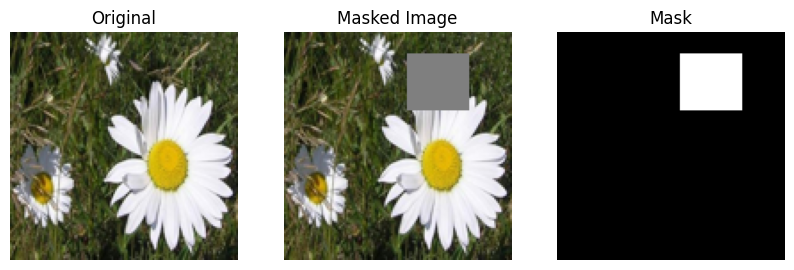

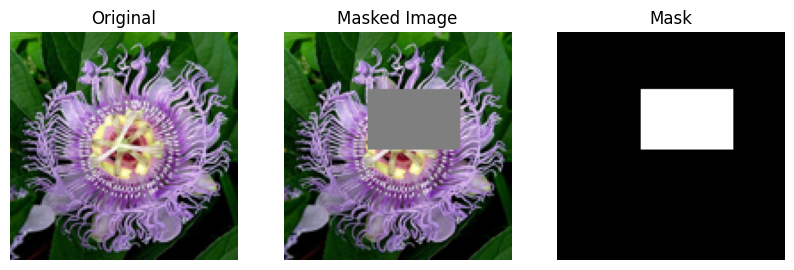

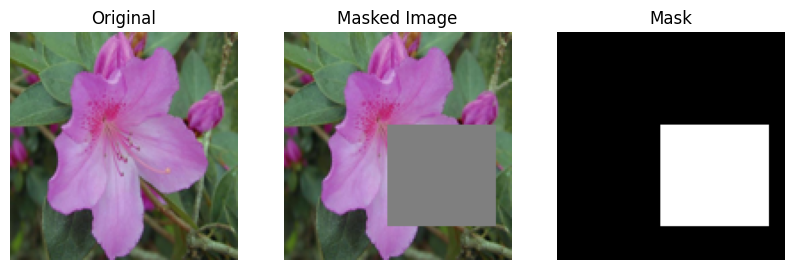

In [36]:
import matplotlib.pyplot as plt

# Denormalization function
def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5  # Reverse normalization
    img_tensor = img_tensor.clamp(0, 1)  # Ensure values stay between 0 and 1
    return img_tensor

# Check few samples
data_iter = iter(train_loader)
originals, masked_images, masks = next(data_iter)

for i in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))

    axs[0].imshow(denormalize(originals[i]).permute(1,2,0))
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(denormalize(masked_images[i]).permute(1,2,0))
    axs[1].set_title('Masked Image')
    axs[1].axis('off')

    axs[2].imshow(masks[i].squeeze(), cmap='gray')
    axs[2].set_title('Mask')
    axs[2].axis('off')

    plt.show()


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super(PartialConv2d, self).__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)
        self.mask_conv.weight.requires_grad = False

        if bias:
            self.input_conv.bias.data.fill_(0.0)

        # Sliding window size (for normalization)
        self.slide_winsize = kernel_size * kernel_size * in_channels

        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, input, mask):
        # Expand mask channels to match input
        if mask.shape[1] != input.shape[1]:
            mask = mask.repeat(1, input.shape[1] // mask.shape[1], 1, 1)

        # Apply masked convolution
        output = self.input_conv(input * mask)

        # Mask convolution (sum of valid areas)
        with torch.no_grad():
            mask_output = self.mask_conv(mask)
            mask_sum = torch.sum(mask_output, dim=(1, 2, 3), keepdim=True)

            mask_ratio = torch.where(mask_sum == 0, torch.zeros_like(mask_sum), self.slide_winsize / (mask_sum + 1e-8))

            mask_output = torch.where(mask_output > 0, torch.ones_like(mask_output), torch.zeros_like(mask_output))

        # Normalize output
        output = output * mask_ratio
        output = self.batch_norm(output)
        output = self.activation(output)

        return output, mask_output

class PConvUNet(nn.Module):
    def __init__(self):
        super(PConvUNet, self).__init__()

        # Encoder
        self.enc1 = PartialConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.enc2 = PartialConv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.enc3 = PartialConv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.enc4 = PartialConv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.enc5 = PartialConv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.enc6 = PartialConv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.enc7 = PartialConv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.enc8 = PartialConv2d(512, 512, kernel_size=3, stride=2, padding=1)

        # Decoder
        self.dec8 = PartialConv2d(512 + 512, 512, kernel_size=3, stride=1, padding=1)
        self.dec7 = PartialConv2d(512 + 512, 512, kernel_size=3, stride=1, padding=1)
        self.dec6 = PartialConv2d(512 + 512, 512, kernel_size=3, stride=1, padding=1)
        self.dec5 = PartialConv2d(512 + 512, 512, kernel_size=3, stride=1, padding=1)
        self.dec4 = PartialConv2d(512 + 256, 256, kernel_size=3, stride=1, padding=1)
        self.dec3 = PartialConv2d(256 + 128, 128, kernel_size=3, stride=1, padding=1)
        self.dec2 = PartialConv2d(128 + 64, 64, kernel_size=3, stride=1, padding=1)
        self.dec1 = PartialConv2d(64 + 3, 3, kernel_size=3, stride=1, padding=1)

        # Activation
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, input, mask):
        # mask = 1 - mask  # Invert mask: 1-valid, 0-missing

        # Encoder
        e1, m1 = self.enc1(input, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)
        e5, m5 = self.enc5(e4, m4)
        e6, m6 = self.enc6(e5, m5)
        e7, m7 = self.enc7(e6, m6)
        e8, m8 = self.enc8(e7, m7)

        # Decoder (Upsample + Concatenate)
        d8_input = torch.cat([F.interpolate(e8, size=e7.shape[2:]), e7], dim=1)
        d8, dm8 = self.dec8(d8_input, m7)

        d7_input = torch.cat([F.interpolate(d8, size=e6.shape[2:]), e6], dim=1)
        d7, dm7 = self.dec7(d7_input, m6)

        d6_input = torch.cat([F.interpolate(d7, size=e5.shape[2:]), e5], dim=1)
        d6, dm6 = self.dec6(d6_input, m5)

        d5_input = torch.cat([F.interpolate(d6, size=e4.shape[2:]), e4], dim=1)
        d5, dm5 = self.dec5(d5_input, m4)

        d4_input = torch.cat([F.interpolate(d5, size=e3.shape[2:]), e3], dim=1)
        d4, dm4 = self.dec4(d4_input, m3)

        d3_input = torch.cat([F.interpolate(d4, size=e2.shape[2:]), e2], dim=1)
        d3, dm3 = self.dec3(d3_input, m2)

        d2_input = torch.cat([F.interpolate(d3, size=e1.shape[2:]), e1], dim=1)
        d2, dm2 = self.dec2(d2_input, m1)

        d1_input = torch.cat([F.interpolate(d2, size=input.shape[2:]), input], dim=1)
        output, _ = self.dec1(d1_input, mask)

        return torch.tanh(output)


In [39]:
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, n_layers=3):
        super(PatchDiscriminator, self).__init__()
        layers = []

        # Initial convolutional layer
        layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # Subsequent layers
        for i in range(1, n_layers):
            layers.append(nn.Conv2d(num_filters * 2**(i-1), num_filters * 2**i, kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(num_filters * 2**i))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        # Final layer
        layers.append(nn.Conv2d(num_filters * 2**(n_layers-1), 1, kernel_size=4, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric


In [41]:
from torchvision.models import VGG16_Weights

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # vgg = models.vgg16(pretrained=True).features[:16]  # up to conv3_3
        vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.feature_extractor = vgg.eval()  # Set to eval
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Disable grads

    def forward(self, gen, target):
        with torch.no_grad():  # No gradients for VGG
            gen_features = self.feature_extractor(gen.detach())
            target_features = self.feature_extractor(target.detach())
        return nn.functional.mse_loss(gen_features, target_features)




In [42]:
def train_model(generator, discriminator, train_loader, test_loader, num_epochs, device):
    # Loss functions
    recon_loss_fn = nn.L1Loss()
    adv_loss_fn = nn.BCELoss()
    perceptual_loss_fn = PerceptualLoss().to(device)

    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        for real_images, masked_images, masks in train_loader:
            real_images = real_images.to(device)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_outputs = discriminator(real_images)
            # Create real labels with the same shape as discriminator output
            real_labels = torch.ones_like(real_outputs, device=device)
            d_real_loss = adv_loss_fn(real_outputs, real_labels)

            gen_images = generator(masked_images, masks)
            fake_outputs = discriminator(gen_images.detach())
            # Create fake labels with the same shape as discriminator output
            fake_labels = torch.zeros_like(fake_outputs, device=device)
            d_fake_loss = adv_loss_fn(fake_outputs, fake_labels)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_outputs = discriminator(gen_images)
            # Use real labels for generator loss
            g_adv_loss = adv_loss_fn(fake_outputs, real_labels)
            g_recon_loss = recon_loss_fn(gen_images * (1 - masks), real_images * (1 - masks))
            g_perceptual_loss = perceptual_loss_fn(gen_images, real_images)

            g_loss = g_adv_loss + 10 * g_recon_loss + 0.1 * g_perceptual_loss
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

        # Save model checkpoints
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

        # Evaluate the model
        evaluate_model(generator, test_loader, device, epoch+1)


In [43]:
import torchvision.transforms as transforms

# Denormalization function assuming [-1, 1] normalization
def denormalize(img_tensor):
    img_tensor = (img_tensor + 1) / 2  # Convert from [-1, 1] to [0, 1]
    img_tensor = torch.clamp(img_tensor, 0, 1)  # Ensure values stay in range
    return img_tensor

def evaluate_model(generator, dataloader, device, epoch):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for real_images, masked_images, masks in dataloader:
            real_images = real_images.to(device)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Forward pass
            gen_images = generator(masked_images, masks)

            # Compute PSNR and SSIM
            for i in range(real_images.size(0)):
                real_img = real_images[i].cpu().numpy().transpose(1, 2, 0)
                gen_img = gen_images[i].cpu().numpy().transpose(1, 2, 0)
                mask = masks[i].cpu().numpy().squeeze()  # Shape (H, W)

                valid_area = (mask == 0)  # Valid pixels (non-masked)

                # PSNR over valid area
                psnr_value = psnr_metric(real_img[valid_area], gen_img[valid_area])
                # SSIM over entire image
                ssim_value = ssim_metric(real_img, gen_img, channel_axis=-1, data_range=1.0)

                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)

            # Save first image (denormalized) for visualization
            denorm_img = denormalize(gen_images[0])
            save_image(denorm_img, f"inpainting_epoch_{epoch}.png")

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    print(f"Epoch [{epoch}], PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

    generator.train()


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


In [45]:
generator = PConvUNet().to(device)
discriminator = PatchDiscriminator().to(device)

In [46]:
train_model(generator, discriminator, train_loader, test_loader, num_epochs=1, device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s] 


Epoch [1/1], Generator Loss: 10.9811, Discriminator Loss: 0.0214
Epoch [1], PSNR: 10.5457, SSIM: -0.0010
